In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dna-sequence-dataset/dog.txt
/kaggle/input/dna-sequence-dataset/example_dna.fa
/kaggle/input/dna-sequence-dataset/human.txt
/kaggle/input/dna-sequence-dataset/chimpanzee.txt


# working with DNA sequence using Biopython

* using Bio.SeqIO from Biopython for parsing DNA sequence data
* we can acsess the sequence of ID, sequence and length of the sequence.

In [2]:
from Bio import SeqIO
for sequence in SeqIO.parse('../input/dna-sequence-dataset/example_dna.fa', "fasta"):
    print(sequence.id)
    print("#"*99)
    print("#"*99)
    print(sequence.seq)
    print("#"*99)
    print("#"*99)
    print(len(sequence))






ENST00000435737.5
###################################################################################################
###################################################################################################
ATGTTTCGCATCACCAACATTGAGTTTCTTCCCGAATACCGACAAAAGGAGTCCAGGGAATTTCTTTCAGTGTCACGGACTGTGCAGCAAGTGATAAACCTGGTTTATACAACATCTGCCTTCTCCAAATTTTATGAGCAGTCTGTTGTTGCAGATGTCAGCAACAACAAAGGCGGCCTCCTTGTCCACTTTTGGATTGTTTTTGTCATGCCACGTGCCAAAGGCCACATCTTCTGTGAAGACTGTGTTGCCGCCATCTTGAAGGACTCCATCCAGACAAGCATCATAAACCGGACCTCTGTGGGGAGCTTGCAGGGACTGGCTGTGGACATGGACTCTGTGGTACTAAATGAAGTCCTGGGGCTGACTCTCATTGTCTGGATTGACTGA
###################################################################################################
###################################################################################################
390
ENST00000419127.5
###################################################################################################
#####################################################################

# how can we use it for machine learning and deep learning
* we loaded our dna sequence data but our data in character or string format.
* we need to encode these characters into matrics
* 1. orfinal encoding DNA Sequence
* 2. one-hot encoding DNA sequence
* 3. DNA sequence as a "language" as k-mer counting


# Ordinal encoding DNA Sequence

* encode each nitrogen base as a ordinal value
* for exmaple: "ATGC" ---> [0.25, 0.5, 0.75, 1.0]
* crete a function for creating Numpy array from a sequence string

In [3]:
import numpy as np
import re

def string_to_array(seq_string):
    seq_string = seq_string.lower()
    seq_string = re.sub('[^acgt]', 'n', seq_string)
    seq_string = np.array(list(seq_string))
    return seq_string

# create a label encoder with 'acgtn' alphabet
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(np.array(['a','c','g','t','z']))

LabelEncoder()

function to encode a DNA sequence string as an ordinal vector 
which return a numpy array with A=0.25, C=0.5, G=0.75, T=1.00, n=0.00

In [4]:
def ordinal_encoder(my_array):
    integer_encoded = label_encoder.transform(my_array)
    float_encoded = integer_encoded.astype(float)
    float_encoded[float_encoded == 0]= 0.25 # A
    float_encoded[float_encoded == 1]= 0.50 # C
    float_encoded[float_encoded == 2]= 0.75 # G
    float_encoded[float_encoded == 3]= 1.00 # T
    float_encoded[float_encoded == 4]= 0.00 # anithing else
    
    return float_encoded

# try it with a simple sequence
seq_test = 'TTCAGCGCAGTG'
ordinal_encoder(string_to_array(seq_test))

array([1.  , 1.  , 0.5 , 0.25, 0.75, 0.5 , 0.75, 0.5 , 0.25, 0.75, 1.  ,
       0.75])

# one-hot encoding DNA sequence

* one-hot encoding is widely used in deep learning and convolutional neural network
* example:
* "ATGC" --> [0,0,0,1],[0,0,1,0],[0,1,0,0],[1,0,0,0]
* these one-hot enocded vectors can be concatenated or turned into 2d arrays

In [5]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encoder(seq_string):
    int_encoded = label_encoder.transform(seq_string)
    onehot_encoder = OneHotEncoder(sparse=False, dtype=int)
    int_encoded = int_encoded.reshape(len(int_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(int_encoded)
    onehot_encoded = np.delete(onehot_encoded, -1, 1)
    return onehot_encoded

# try it out with simple exmaple
seq_test = 'ATGCATGCATGC'
one_hot_encoder(string_to_array(seq_test))

array([[1, 0, 0],
       [0, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 0],
       [0, 0, 1],
       [0, 1, 0]])

# DNA sequence as a “language”, known as k-mer counting

* A hurdle that still remains is that none of these above methods results in vectors of uniform length, and that is a necessity for feeding data to a classification or regression algorithm. So with the above methods, you have to resort to things like truncating sequences or padding with “n” or “0” to get vectors of uniform length.

* DNA and protein sequences can be seen as the language of life. The language encodes instructions as well as functions for the molecules that are found in all life forms. The sequence language resemblance continues with the genome as the book, subsequences (genes and gene families) are sentences and chapters, k-mers and peptides are words, and nucleotide bases and amino acids are the alphabets. Since the relationship seems so likely, it stands to reason that the natural language processing(NLP) should also implement the natural language of DNA and protein sequences.

* The method we use here is manageable and easy. We first take the long biological sequence and break it down into k-mer length overlapping “words”. For example, if we use “words” of length 6 (hexamers), “ATGCATGCA” becomes: ‘ATGCAT’, ‘TGCATG’, ‘GCATGC’, ‘CATGCA’. Hence our example sequence is broken down into 4 hexamer words.

* In genomics, we refer to these types of manipulations as “k-mer counting”, or counting the occurrences of each possible k-mer sequence and Python natural language processing tools make it super easy.

In [6]:
def Kmers_funct(seq, size):
    return [seq[x:x+size].lower() for x in range(len(seq) - size + 1)]

# try it out with simple example
mySeq = 'GTGCCCAGGTTCAGTGAGTGACACAGGCAG'
Kmers_funct(mySeq, size=9)

['gtgcccagg',
 'tgcccaggt',
 'gcccaggtt',
 'cccaggttc',
 'ccaggttca',
 'caggttcag',
 'aggttcagt',
 'ggttcagtg',
 'gttcagtga',
 'ttcagtgag',
 'tcagtgagt',
 'cagtgagtg',
 'agtgagtga',
 'gtgagtgac',
 'tgagtgaca',
 'gagtgacac',
 'agtgacaca',
 'gtgacacag',
 'tgacacagg',
 'gacacaggc',
 'acacaggca',
 'cacaggcag']

It returns a list of k-mer “words.” You can then join the “words” into a “sentence”, then apply your favorite natural language processing methods on the “sentences” as you normally would.



In [7]:
words = Kmers_funct(mySeq, size=7)
joined_sentence = ' '.join(words)
joined_sentence

'gtgccca tgcccag gcccagg cccaggt ccaggtt caggttc aggttca ggttcag gttcagt ttcagtg tcagtga cagtgag agtgagt gtgagtg tgagtga gagtgac agtgaca gtgacac tgacaca gacacag acacagg cacaggc acaggca caggcag'

You can tune both the word length and the amount of overlap. This allows you to determine how the DNA sequence information and vocabulary size will be important in your application. For example, if you use words of length 6, and there are 4 letters, you have a vocabulary of size 4096 possible words. You can then go on and create a bag-of-words model like you would in NLP.

Let’s make a couple more “sentences” to make it more interesting.

In [8]:
mySeq1 = 'TCTCACACATGTGCCAATCACTGTCACCC'
mySeq2 = 'GTGCCCAGGTTCAGTGAGTGACACAGGCAG'
sentence1 = ' '.join(Kmers_funct(mySeq1, size=6))
sentence2 = ' '.join(Kmers_funct(mySeq2, size=6))
print("*"*20)
print(sentence1)
print("*"*20)
print(sentence2)

********************
tctcac ctcaca tcacac cacaca acacat cacatg acatgt catgtg atgtgc tgtgcc gtgcca tgccaa gccaat ccaatc caatca aatcac atcact tcactg cactgt actgtc ctgtca tgtcac gtcacc tcaccc
********************
gtgccc tgccca gcccag cccagg ccaggt caggtt aggttc ggttca gttcag ttcagt tcagtg cagtga agtgag gtgagt tgagtg gagtga agtgac gtgaca tgacac gacaca acacag cacagg acaggc caggca aggcag


In [9]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X = cv.fit_transform([joined_sentence, sentence1, sentence2]).toarray()
X

array([[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
        0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
        0, 0, 1, 0, 0, 0, 1],
       [1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 1, 1, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
        1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
        0, 1, 0, 0, 0, 1, 0]])

# Objective:
* Build a classification model that is trained on the human DNA sequence and can predict a gene family based on the DNA sequence of the coding sequence. To test the model, we will use the DNA sequence of humans, dogs, and chimpanzees and compare the accuracies.

* Gene families are groups of related genes that share a common ancestor. Members of gene families may be paralogs or orthologs. Gene paralogs are genes with similar sequences from within the same species while gene orthologs are genes with similar sequences in different species.

* The dataset contains human DNA sequence, Dog DNA sequence, and Chimpanzee DNA sequence.

In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
%matplotlib inline
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dna-sequence-dataset/dog.txt
/kaggle/input/dna-sequence-dataset/example_dna.fa
/kaggle/input/dna-sequence-dataset/human.txt
/kaggle/input/dna-sequence-dataset/chimpanzee.txt


In [11]:
# load human data
human_dna = pd.read_table('/kaggle/input/dna-sequence-dataset/human.txt')
human_dna.head()

,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3


Text(0.5, 1.0, 'Class distribution of human DNA')

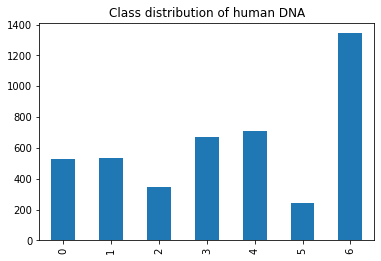

In [12]:
human_dna['class'].value_counts().sort_index().plot.bar()
plt.title("Class distribution of human DNA")

In [13]:
chimp_dna = pd.read_table('../input/dna-sequence-dataset/chimpanzee.txt')
chimp_dna.head()


,sequence,class
0,ATGCCCCAACTAAATACCGCCGTATGACCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTATTCGCTTCATTCGCTGCCCCCACAATCCTAG...,4
2,ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...,4
3,ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...,4
4,ATGGGCAGCGCCAGCCCGGGTCTGAGCAGCGTGTCCCCCAGCCACC...,6


Text(0.5, 1.0, 'Class distribution of Chimpanzee DNA')

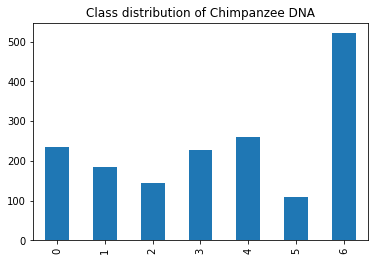

In [14]:
chimp_dna['class'].value_counts().sort_index().plot.bar()
plt.title("Class distribution of Chimpanzee DNA")


In [15]:
dog_dna = pd.read_table('../input/dna-sequence-dataset/dog.txt')
dog_dna.head()

,sequence,class
0,ATGCCACAGCTAGATACATCCACCTGATTTATTATAATCTTTTCAA...,4
1,ATGAACGAAAATCTATTCGCTTCTTTCGCTGCCCCCTCAATAATAG...,4
2,ATGGAAACACCCTTCTACGGCGATGAGGCGCTGAGCGGCCTGGGCG...,6
3,ATGTGCACTAAAATGGAACAGCCCTTCTACCACGACGACTCATACG...,6
4,ATGAGCCGGCAGCTAAACAGAAGCCAGAACTGCTCCTTCAGTGACG...,0


Text(0.5, 1.0, 'Class distribution of Dog DNA')

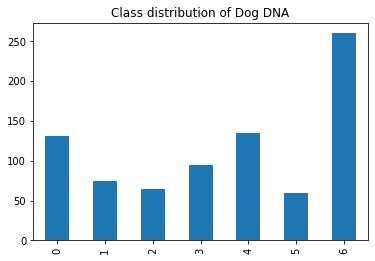

In [16]:
dog_dna['class'].value_counts().sort_index().plot.bar()
plt.title("Class distribution of Dog DNA")


Now we have all our data loaded, the next step is to convert a sequence of characters into k-mer words, default size = 6 (hexamers). The function Kmers_funct() will collect all possible overlapping k-mers of a specified length from any sequence string.



In [17]:
def Kmers_funct(seq, size=6):
    return [seq[x:x+size].lower() for x in range(len(seq) - size + 1)]


#convert our training data sequences into short overlapping k-mers of length 6. 
#Lets do that for each species of data we have using our Kmers_funct function.

human_dna['words'] = human_dna.apply(lambda x: Kmers_funct(x['sequence']), axis=1)
human_dna = human_dna.drop('sequence', axis=1)

chimp_dna['words'] = chimp_dna.apply(lambda x: Kmers_funct(x['sequence']), axis=1)
chimp_dna = chimp_dna.drop('sequence', axis=1)

dog_dna['words'] = dog_dna.apply(lambda x: Kmers_funct(x['sequence']), axis=1)
dog_dna = dog_dna.drop('sequence', axis=1)

The DNA sequence is changed to lowercase, divided into all possible k-mer words of length 6, and ready for the next step.



In [18]:
human_dna.head()

,class,words
0,4,"[atgccc, tgcccc, gcccca, ccccaa, cccaac, ccaac..."
1,4,"[atgaac, tgaacg, gaacga, aacgaa, acgaaa, cgaaa..."
2,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
3,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
4,3,"[atgcaa, tgcaac, gcaaca, caacag, aacagc, acagc..."


We need to now convert the lists of k-mers for each gene into string sentences of words that can be used to create the Bag of Words model. We will make a target variable y to hold the class labels

In [19]:
human_texts = list(human_dna['words'])
for item in range(len(human_texts)):
    human_texts[item] = ' '.join(human_texts[item])
    
# seperate lables
y_human = human_dna.iloc[:, 0].values 

same for chimp and dog

In [20]:
chimp_texts = list(chimp_dna['words'])
for item in range(len(chimp_texts)):
    chimp_texts[item] = ' '.join(chimp_texts[item])
    
# seperate labels
y_chimp = chimp_dna.iloc[:, 0].values

dog_texts = list(dog_dna['words'])
for item in range(len(dog_texts)):
    dog_texts[item] = ' '.join(dog_texts[item])
    
# seperate labels
y_dog = dog_dna.iloc[:, 0].values

In [21]:
y_human

array([4, 4, 3, ..., 6, 6, 6])

Creating the Bag of Words model using CountVectorizer(). This is equivalent to k-mer counting. The n-gram size of 4 was previously determined by testing.

Convert our k-mer words into uniform length numerical vectors that represent counts for every k-mer in the vocabulary:



In [22]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(4,4))
#The n-gram size of 4 is previously determined by testing

X = cv.fit_transform(human_texts)
X_chimp = cv.transform(chimp_texts)
X_dog = cv.transform(dog_texts)

In [23]:
print(X.shape)
print(X_chimp.shape)
print(X_dog.shape)

(4380, 232414)
(1682, 232414)
(820, 232414)


So, for humans we have 4380 genes converted into uniform length feature vectors of 4-gram k-mer (length 6) counts. For chimp and dog, we have the same number of features with 1682 and 820 genes respectively.

So now that we know how to transform our DNA sequences into uniform length numerical vectors in the form of k-mer counts and ngrams, we can now go ahead and build a classification model that can predict the DNA sequence function based only on the sequence itself.

Here I will use the human data to train the model, holding out 20% of the human data to test the model. Then we can challenge the model’s generalizability by trying to predict sequence function in other species (the chimpanzee and dog).

Next, train/test split human dataset and build simple multinomial naive Bayes classifier.

You might want to do some parameter tuning and build a model with different ngram sizes, here I’ll go ahead with an ngram size of 4 and a model alpha of 0.1.

In [24]:
# Splitting the human dataset into the training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y_human, 
                                                    test_size = 0.20, 
                                                    random_state=42)

We will create a multinomial naive Bayes classifier. I previously did some parameter tuning and found the ngram size of 4 (reflected in the Countvectorizer() instance) and a model alpha of 0.1 did the best. Just to keep it simple I won't show that code here.

In [25]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB(alpha=0.1)
classifier.fit(X_train, y_train)

MultinomialNB(alpha=0.1)

Now let's make predictions on the human hold out test set and see how it performes on unseen data.¶


In [26]:
y_pred = classifier.predict(X_test)


Okay, so let's look at some model performce metrics like the confusion matrix, accuracy, precision, recall and f1 score. We are getting really good results on our unseen data, so it looks like our model did not overfit to the training data. In a real project I would go back and sample many more train test splits since we have a relatively small data set.



In [27]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("Confusion matrix for predictions on human test DNA sequence\n")
print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')))
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Confusion matrix for predictions on human test DNA sequence

Predicted   0    1   2    3    4   5    6
Actual                                   
0          99    0   0    0    1   0    2
1           0  104   0    0    0   0    2
2           0    0  78    0    0   0    0
3           0    0   0  124    0   0    1
4           1    0   0    0  143   0    5
5           0    0   0    0    0  51    0
6           1    0   0    1    0   0  263
accuracy = 0.984 
precision = 0.984 
recall = 0.984 
f1 = 0.984


Now for the real test. Let's see how our model perfoms on the DNA sequences from other species. First we'll try the Chimpanzee, which we would expect to be very similar to human. Then we will try man's (and woman's) best friend, the Dog DNA sequences.



In [28]:
# Predicting the chimp, dog sequences
y_pred_chimp = classifier.predict(X_chimp)


In [29]:
# performance on chimpanzee genes
print("Confusion matrix for predictions on Chimpanzee test DNA sequence\n")
print(pd.crosstab(pd.Series(y_chimp, name='Actual'), pd.Series(y_pred_chimp, name='Predicted')))
accuracy, precision, recall, f1 = get_metrics(y_chimp, y_pred_chimp)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))


Confusion matrix for predictions on Chimpanzee test DNA sequence

Predicted    0    1    2    3    4    5    6
Actual                                      
0          232    0    0    0    0    0    2
1            0  184    0    0    0    0    1
2            0    0  144    0    0    0    0
3            0    0    0  227    0    0    1
4            2    0    0    0  254    0    5
5            0    0    0    0    0  109    0
6            0    0    0    0    0    0  521
accuracy = 0.993 
precision = 0.994 
recall = 0.993 
f1 = 0.993


Let us now do predictions on Dog test DNA sequence.



In [30]:
y_pred_dog = classifier.predict(X_dog)


In [31]:
# performance on dog genes
print("Confusion matrix for predictions on Dog test DNA sequence\n")
print(pd.crosstab(pd.Series(y_dog, name='Actual'), pd.Series(y_pred_dog, name='Predicted')))
accuracy, precision, recall, f1 = get_metrics(y_dog, y_pred_dog)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Confusion matrix for predictions on Dog test DNA sequence

Predicted    0   1   2   3    4   5    6
Actual                                  
0          127   0   0   0    0   0    4
1            0  63   0   0    1   0   11
2            0   0  49   0    1   0   14
3            1   0   0  81    2   0   11
4            4   0   0   1  126   0    4
5            4   0   0   0    1  53    2
6            0   0   0   0    0   0  260
accuracy = 0.926 
precision = 0.934 
recall = 0.926 
f1 = 0.925
